In [4]:
# import generator from '../data/generator.py'
import sys
import os
from generator import *

# Graph Generation

In [12]:
n = [10, 20]
p = 0.3

dataset = RandomGraphDataset(root='./data', gen_num_graph=500, n=n, p=p)

Generating 500 graphs


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 869.69it/s]
Processing...
100%|██████████| 500/500 [00:01<00:00, 269.81it/s]
Done!


In [14]:
for i in range(dataset.len()):
    test_data = dataset[i]
    t1 = test_data.pi
    t2 = test_data.reach_h[-1]
    y = torch.zeros(len(test_data.s))
    for node_index in np.arange(0, len(test_data.s)):
        alpha_max_proba = t1[torch.logical_or(test_data.edge_index[0] == node_index, test_data.edge_index[1] == node_index)].max()
        if alpha_max_proba.item() == 1:
            y[node_index] = 1
    # if y is the same as t2 then the test is passed else failed
    if not torch.equal(y, t2):
        print("Test Failed")
        print("t1: ", t1)
        print("t2: ", t2)
        print("y: ", y)
        sys.exit(1)
print("Test Passed")

Test Passed


In [178]:
y = np.zeros(len(test_data.s))
for node_index in np.arange(0, len(test_data.s)):
    alpha_max_proba = t1[torch.logical_or(test_data.edge_index[0] == node_index, test_data.edge_index[1] == node_index)].max()
    if alpha_max_proba.item() >= 0.9:
        y[node_index] = 1
y == t2

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

In [166]:
(test_data.reach_h[-1])

35

In [19]:
import torch
from torch import nn
from encoder import Encoder
from decoder import Decoder
from mpnn import MPNN
from torch.functional import F

class Network(nn.Module):
    def __init__(self, latent_dim=128):
        super(Network, self).__init__()
        self.encoder = Encoder(2, latent_dim)
        self.encoder_bn = nn.BatchNorm1d(latent_dim)
        self.processor = MPNN(latent_dim*2, latent_dim)
        self.processor_bn = nn.BatchNorm1d(latent_dim)
        self.decoder = Decoder(latent_dim, 1)

    def forward(self, batch, max_iter=10):
        input = torch.stack((batch.pos, batch.s), dim=1).float()
        h = torch.zeros(input.size(0), 128) # hidden state from the processor
        hints = batch.pi_h[1:] # hints if an edge was passed or not
        true_output = batch.pi # true_output for all the edges if they were passed or not at the end.
        max_iter = hints.size(0)+1
        predictions = torch.zeros(max_iter, batch.pi.size(0))
        predictions_y = torch.zeros(max_iter, batch.s.size(0))
        hints_reach = batch.reach_h[1:] # hints from the reachability
        true_output_reach = batch.reach_h[-1] # true_output expected from the reachability
        for i in range(max_iter):
            z = self.encoder(input) # the encoded input
            #z = self.encoder_bn(z) # batch normalization
            processor_input = torch.cat([z, h], dim=1) # the input to the processor
            h = self.processor(processor_input, batch.edge_index.long()) # the output of the processor
            #h = self.processor_bn(h) # batch normalization
            decoder_input = torch.cat((h[batch.edge_index[0]], h[batch.edge_index[1]]), dim=1)
            alpha = self.decoder(decoder_input).view(batch.pi.size(0))

            predictions[i] = alpha.view(batch.pi.size(0))

            y = torch.zeros((len(batch.s)))
            for node_index in np.arange(0, len(batch.s)):
                alpha_max_proba = alpha[torch.logical_or(batch.edge_index[0] == node_index, batch.edge_index[1] == node_index)].max()
                #print(alpha_max_proba)
                if alpha_max_proba.item() >= 0.8:
                    #print(alpha_max_proba)
                    y[node_index] = 1
            predictions_y[i] = y

            input = torch.stack((batch.pos, y), dim=1).float() # we update the input with the new state

        loss = self.calculate_loss(hints, predictions, true_output)
        y_loss = self.calculate_loss(hints_reach, predictions_y, true_output_reach)
        return y, loss, y_loss
    
    def calculate_loss(self, hints, predictions, true_output):
        loss_x = F.binary_cross_entropy(predictions[-1], true_output.type(torch.float))
        loss_h = 0
        for i in range(hints.size(0)):
            loss_h += F.binary_cross_entropy(predictions[i], hints[i].type(torch.float))
        return loss_x, loss_h
    
    def calculate_y_loss(self, hints, predictions, true_output):
        loss_y = torch.tensor(0) if torch.all(predictions[-1] == true_output) else torch.tensor(1)
        loss_h = torch.tensor(0) # Initialize loss_h as a tensor
        for i in range(hints.size(0)):
            loss_h += torch.tensor(0) if torch.all(predictions[i] == hints[i]) else torch.tensor(1)
        return loss_y, loss_h


In [ ]:
import torch
from torch import nn
from encoder import Encoder
from decoder import Decoder
from mpnn import MPNN
from torch.functional import F

class Network(nn.Module):
    def __init__(self, latent_dim=128):
        super(Network, self).__init__()
        self.encoder = Encoder(2, latent_dim)
        self.encoder_bn = nn.BatchNorm1d(latent_dim)
        self.processor = MPNN(latent_dim*2, latent_dim)
        self.processor_bn = nn.BatchNorm1d(latent_dim)
        self.decoder = Decoder(latent_dim, 1)

    def forward(self, batch, max_iter=10):
        input = torch.stack((batch.pos, batch.s), dim=1).float()
        h = torch.zeros(input.size(0), 128) # hidden state from the processor
        hints = batch.pi_h[1:] # hints if an edge was passed or not
        true_output = batch.pi # true_output for all the edges if they were passed or not at the end.
        max_iter = hints.size(0)+1
        predictions = torch.zeros(max_iter, batch.pi.size(0))
        predictions_y = torch.zeros(max_iter, batch.s.size(0))
        hints_reach = batch.reach_h[1:] # hints from the reachability
        true_output_reach = batch.reach_h[-1] # true_output expected from the reachability
        for i in range(max_iter):
            z = self.encoder(input) # the encoded input
            #z = self.encoder_bn(z) # batch normalization
            processor_input = torch.cat([z, h], dim=1) # the input to the processor
            h = self.processor(processor_input, batch.edge_index.long()) # the output of the processor
            #h = self.processor_bn(h) # batch normalization
            decoder_input = torch.cat((h[batch.edge_index[0]], h[batch.edge_index[1]]), dim=1)
            alpha = self.decoder(decoder_input).view(batch.pi.size(0))

            predictions[i] = alpha.view(batch.pi.size(0))

            y = torch.zeros((len(batch.s))) # the output of the reachability

            parents = torch.zeros((len(batch.s))) # the predicted parents of the nodes
            real_parents = torch.zeros((len(batch.s)))

            for node_index in np.arange(0, len(batch.s)):
                # maximum probability of all the edges connected to the node
                alpha_max_proba = alpha[torch.logical_or(batch.edge_index[0] == node_index, batch.edge_index[1] == node_index)].max() # maximum probability of all the edges connected to the node
                
                # argmax of the maximum probability of all the edges connected to the node as the parent
                arg_max_proba = alpha[batch.edge_index[1] == node_index].argmax()
                parent = batch.edge_index[0][arg_max_proba]

                # find real parent
                arg_max_real = batch.pi[torch.logical_or(batch.edge_index[0] == node_index, batch.edge_index[1] == node_index)].argmax()
                real_parent = batch.edge_index[0][arg_max_real]
                #print(alpha_max_proba)
                if alpha_max_proba.item() >= 0.8:
                    #print(alpha_max_proba)
                    y[node_index] = 1
                parents[node_index] = parent
            
            predictions_y[i] = y

            input = torch.stack((batch.pos, y), dim=1).float() # we update the input with the new state

        loss = self.calculate_loss(hints, predictions, true_output)
        y_loss = self.calculate_loss(hints_reach, predictions_y, true_output_reach)
        return y, loss, y_loss
    
    def calculate_loss(self, hints, predictions, true_output):
        loss_x = F.binary_cross_entropy(predictions[-1], true_output.type(torch.float))
        loss_h = 0
        for i in range(hints.size(0)):
            loss_h += F.binary_cross_entropy(predictions[i], hints[i].type(torch.float))
        return loss_x, loss_h
    
    def calculate_y_loss(self, hints, predictions, true_output):
        loss_y = torch.tensor(0) if torch.all(predictions[-1] == true_output) else torch.tensor(1)
        loss_h = torch.tensor(0) # Initialize loss_h as a tensor
        for i in range(hints.size(0)):
            loss_h += torch.tensor(0) if torch.all(predictions[i] == hints[i]) else torch.tensor(1)
        return loss_y, loss_h


In [35]:
batch = dataset[0]
real_parents = torch.zeros((len(batch.s)))
for node_index in np.arange(0, len(batch.s)):
    arg_max_proba = batch.pi[batch.edge_index[1] == node_index].argmax()
    parent = batch.edge_index[0][arg_max_proba]
    real_parents[node_index] = parent

real_parents

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, 

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
batch.edge_index[0][batch.pi[batch.edge_index[1] == node_index].argmax()]

tensor(0)

In [32]:
batch.reach_h[-1]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)

In [71]:
def get_parents(pi, edge_index, s):
    parents = torch.full((len(s),), -1, dtype=torch.long)
    for child in range(len(s)):
        indices = (edge_index[1] == child).nonzero(as_tuple=False).squeeze()
        passed_indices = indices[pi[indices] == 1]
        if passed_indices.numel() > 0:
            parent_index = edge_index[0, passed_indices[0]]
            parents[child] = parent_index.item()
    return parents

batch = dataset[0]
get_parents(batch.pi, batch.edge_index, batch.s)

tensor([ 1, 25, 25,  1, 15, 39,  1,  1,  1, 15, 25, 25,  1, 10, 25, 25, 25, 25,
         1,  1,  1,  1, 25, 25,  1, -1, 25,  2,  2,  2,  2,  2, 25,  2, 14, 10,
        16, 23, 10, 25, 25, 25, 15, 10, 25, 15, 25, 23])

In [74]:
# get index of -1 in the parents
parents = get_parents(batch.pi, batch.edge_index, batch.s)

torch.where(parents == -1)

(tensor([25]),)

In [61]:
len(batch.pi[batch.edge_index[1] == 9])

18

In [66]:
batch.pi[batch.edge_index[1] == 3]

704

In [46]:
batch.edge_index[0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13,
        13, 13, 13, 14, 14, 14, 14, 14, 

In [42]:
batch.edge_index[0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
         4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
        12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,
        18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 

In [20]:
def train(model, train_dataset, validation_dataset=None, optimizer=None, epochs=10, batch_size=5):
    x_loss_weight = 0.5
    h_loss_weight = 1 - x_loss_weight
    # for plotting save the losses
    train_losses = []
    val_losses = []
    y_losses = []
    y_val_losses = []
    for epoch in range(epochs):
        batch_count = len(train_dataset) // batch_size
        for i in range(batch_count):
            model.train()
            cumulated_loss = 0
            cumulated_y_loss = 0
            for j in range(i*batch_size, (i+1)*batch_size):
                graph = train_dataset[j] 
                y, loss, y_loss = model(graph)
                loss_x, loss_hints = loss[0], loss[1] # loss for the output
                
                y_loss_x, y_loss_hints = y_loss[0], y_loss[1] # loss for the hints

                cumulated_loss += x_loss_weight * loss_x + h_loss_weight * loss_hints
                cumulated_y_loss += x_loss_weight * y_loss_x + h_loss_weight * y_loss_hints
            
            cumulated_loss /= batch_size
            cumulated_y_loss /= batch_size

            optimizer.zero_grad()
            cumulated_loss.backward()
            optimizer.step()

        train_losses.append(cumulated_loss.item()) 
        y_losses.append(cumulated_y_loss.item())

        if validation_dataset:
            model.eval()
            cumulated_loss_val = 0
            cumulated_y_loss_val = 0
            with torch.no_grad():
                for k in range(len(validation_dataset)):
                    graph = validation_dataset[k]
                    y, loss, y_loss = model(graph)

                    loss_x, loss_hints = loss[0], loss[1]
                    y_loss_x, y_loss_hints = y_loss[0], y_loss[1]

                    cumulated_loss_val += x_loss_weight * loss_x + h_loss_weight * loss_hints
                    cumulated_y_loss_val += x_loss_weight * y_loss_x + h_loss_weight * y_loss_hints

            cumulated_loss_val /= len(validation_dataset)
            cumulated_y_loss_val /= len(validation_dataset)

            print(f'Epoch {epoch}, loss {cumulated_loss:.4f}, validation loss {cumulated_loss_val:.4f} || '
                  f'y_loss {cumulated_y_loss:.4f}, validation y_loss {cumulated_y_loss_val:.4f}')
            val_losses.append(cumulated_loss_val.item())
            y_val_losses.append(cumulated_y_loss_val.item())

        else:
            print(f'Epoch {epoch}, loss {cumulated_loss.item()}')
        
        # EARLY STOPPING
        if len(val_losses) > 5:
                    if val_losses[-1] > val_losses[-2] > val_losses[-3] > val_losses[-4] > val_losses[-5]:
                        print('Early stopping')
                        break
    return train_losses, val_losses, y_losses, y_val_losses


In [21]:
# split the dataset into training and testing using the train_test_split function
from torch.utils.data import random_split
from generator import *
n=[20, 50]
p=0.3
dataset = RandomGraphDataset(root='./data/medium', gen_num_graph=200, n=n, p=p)
train_dataset, test_dataset = random_split(dataset, [150, 50])

In [26]:
optimizer = torch.optim.Adam
model = Network()
lr = 0.0002

train_loss, val_losses, y_losses, y_val_losses = train(model=model, train_dataset=train_dataset, validation_dataset=test_dataset,
      optimizer=optimizer(model.parameters(), lr=lr), epochs=200, batch_size=32)

Epoch 0, loss 1.2083, validation loss 1.1260 || y_loss 149.4962, validation y_loss 141.4539
Epoch 1, loss 1.0875, validation loss 1.0056 || y_loss 149.4962, validation y_loss 141.4539
Epoch 2, loss 0.9503, validation loss 0.8653 || y_loss 149.4962, validation y_loss 141.4539
Epoch 3, loss 0.7959, validation loss 0.7118 || y_loss 149.4962, validation y_loss 141.4539
Epoch 4, loss 0.6601, validation loss 0.5878 || y_loss 149.4962, validation y_loss 141.4539
Epoch 5, loss 0.6151, validation loss 0.5590 || y_loss 149.4962, validation y_loss 141.4539
Epoch 6, loss 0.6411, validation loss 0.5713 || y_loss 149.4962, validation y_loss 141.4539
Epoch 7, loss 0.6245, validation loss 0.5501 || y_loss 149.4962, validation y_loss 141.4539
Epoch 8, loss 0.5942, validation loss 0.5302 || y_loss 149.4962, validation y_loss 141.4539
Epoch 9, loss 0.5825, validation loss 0.5264 || y_loss 149.4962, validation y_loss 141.4539
Epoch 10, loss 0.5800, validation loss 0.5253 || y_loss 149.4962, validation y_l

In [5]:
# split the dataset into training and testing using the train_test_split function
from torch.utils.data import random_split
n=[20, 100]
p=0.3
dataset = RandomGraphDataset(root='./data', gen_num_graph=500, n=n, p=p)
train_dataset, test_dataset = random_split(dataset, [400, 100])

Generating 500 graphs


100%|██████████| 500/500 [00:02<00:00, 206.15it/s]
Processing...
100%|██████████| 500/500 [00:14<00:00, 35.58it/s]
Done!


In [ ]:
# create a test set
n=[100, 1000]
p=0.3

test_dataset = RandomGraphDataset(root='./data/test', gen_num_graph=100, n=n, p=p)

In [17]:
optimizer = torch.optim.Adam
model = Network()
lr = 0.001

train_loss, val_losses = train(model=model, train_dataset=train_dataset, validation_dataset=test_dataset,
      optimizer=optimizer(model.parameters(), lr=lr), epochs=15, batch_size=32)

Epoch 0, loss 0.474441260099411, validation loss 0.483560174703598
Epoch 1, loss 0.2088150680065155, validation loss 0.18745948374271393
Epoch 2, loss 0.008495943620800972, validation loss 0.006550794932991266
Epoch 3, loss 0.00042512972140684724, validation loss 0.00037600912037305534
Epoch 4, loss 9.510121890343726e-05, validation loss 9.221333311870694e-05
Epoch 5, loss 4.748110950458795e-05, validation loss 4.7312365495599806e-05
Epoch 6, loss 3.1041312468005344e-05, validation loss 3.187461697962135e-05
Epoch 7, loss 2.4472823497490026e-05, validation loss 2.5687741072033532e-05
Epoch 8, loss 2.107813816110138e-05, validation loss 2.2359427021001466e-05
Epoch 9, loss 1.8665112293092534e-05, validation loss 1.9870582036674023e-05
Epoch 10, loss 1.6638863598927855e-05, validation loss 1.77220645127818e-05
Epoch 11, loss 1.4860472219879739e-05, validation loss 1.5818113752175122e-05
Epoch 12, loss 1.3286005014379043e-05, validation loss 1.4136039681034163e-05
Epoch 13, loss 1.1898310

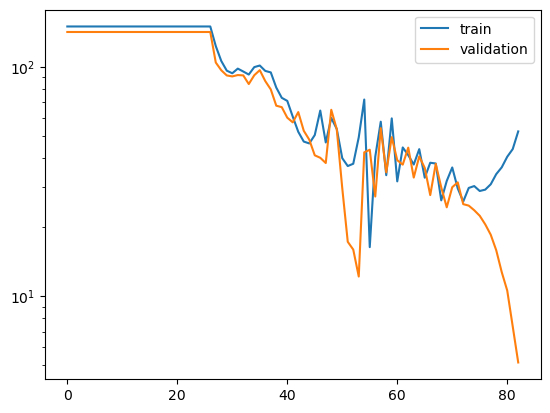

In [24]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(y_losses, label='train')
plt.plot(y_val_losses, label='validation')
plt.legend()
# use log scale
plt.yscale('log')
plt.show()

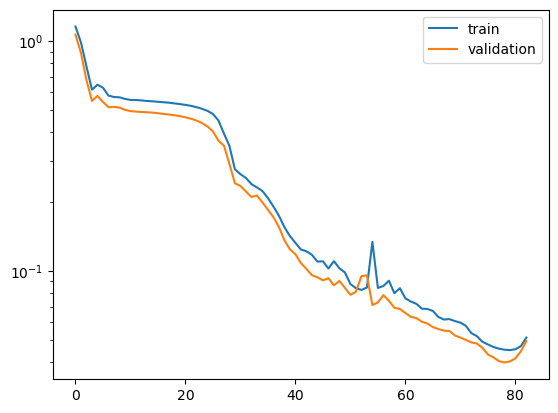

In [25]:
plt.plot(train_loss, label='train')
plt.plot(val_losses, label='validation')
plt.legend()
# use log scale
plt.yscale('log')
plt.show()

In [ ]:
i =31
graph = test_dataset[i]
print(graph.reach_h[-1])
print(torch.sigmoid(model(graph)[0]))

tensor([1., 0., 1., 1., 1., 0.], dtype=torch.float64)
tensor([1.0000, 0.0507, 1.0000, 1.0000, 1.0000, 0.0255],
       grad_fn=<SigmoidBackward0>)


In [ ]:
model(graph)[0]

tensor([3500525.5000, 3524301.5000, 3249399.0000, 3501471.5000, 3512054.0000,
        3518177.7500], grad_fn=<ViewBackward0>)

In [35]:
(dataset[0].pi_h[-1] == dataset[0].pi).all()

tensor(True)

In [ ]:
Network().forward(input, dataset[0].edge_index)

tensor([[-0.0748],
        [-0.0829],
        [-0.0641],
        [-0.0551],
        [-0.0525],
        [-0.0458]], grad_fn=<AddmmBackward0>)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.lin = nn.Linear(input_dim, hidden_dim)

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(-1)
        return self.lin(x)

In [ ]:
encoder = Encoder(2)
z = encoder(input)

In [ ]:
h = torch.zeros(input.size(0), 128)

In [ ]:
z_ = torch.cat([z, h], dim=1)
z_.size()

torch.Size([6, 256])

In [ ]:
import torch
from torch_geometric.nn import MessagePassing
from torch.nn import Linear

class MPNN(MessagePassing):
  def __init__(self, in_channels, hidden_channels, activation=None):
    super(MPNN, self).__init__(aggr='max') #  "Max" aggregation.
    self.in_channels = in_channels
    self.hidden_channels = hidden_channels
    self.messages = Linear(self.in_channels * 2, self.hidden_channels)
    self.update_fn = Linear(self.in_channels + self.hidden_channels, self.hidden_channels)
    self.activation = activation

    self.mlp = torch.nn.Sequential(
        Linear(hidden_channels, hidden_channels),
        torch.nn.ReLU(),
        Linear(hidden_channels, self.hidden_channels)
    )
    
  def forward(self, x, edge_index):
    out = self.propagate(edge_index, x=x)
    out = self.mlp(out)
    if self.activation is not None:
      out = self.activation(out)
    return out
    
  def message(self, x_i, x_j):
    # x_i has shape [E, in_channels]
    # x_j has shape [E, in_channels]
    #print('MPNN => xi, xj', x_i.size(), x_j.size())
    tmp = torch.cat([x_i, x_j], dim=1)  # tmp has shape [E, 2 * in_channels]
    #print('MPNN => messages IN', tmp.size())
    m = self.messages(tmp)
    #print('MPNN => messages OUT', m.size())
    return m
  
  def update(self, aggr_out, x):
    # aggr_out has shape [N, out_channels]
    # x has shape [N, in_channels]
    #print(f'MPNN => x_i', x.size(), ' aggr_out ', aggr_out.size())
    tmp = torch.cat([x, aggr_out], dim=1)
    #print(f'MPNN => tmp', tmp.size())
    return self.update_fn(tmp)

In [ ]:
processor = MPNN(256, 128)

In [ ]:
hi = processor(z_, dataset[0].edge_index)

In [ ]:
hi.size()

torch.Size([6, 128])